In [26]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
import astropy.units as u
import astropy.coordinates as coord
from astroquery.vizier import Vizier
%matplotlib inline
from astropy.io import fits
from astroquery.simbad import Simbad
import matplotlib
import aplpy
from astroquery.sdss import SDSS
from astroquery.skyview import SkyView
from astropy.coordinates import Angle
import time
from astropy.table import Table
import heapq
from math import log10, floor
import matplotlib.mlab as mlab

In [2]:
#Region of Sky:

RA=196.875
DE=51.0
RA_length=35.625
DE_length=6.0

#Catalogues:

First_Catalogue_Name='LOTSS'
Second_Catalogue_Name='TGSS'

In [3]:
#Name of Flux in Catalogue..

First_Flux='FTot'
Second_Flux='Stotal'

#And their error
First_Flux_error='e_'+First_Flux
Second_Flux_error='e_'+Second_Flux

In [4]:
# #Getting data from first catalogue

# Vizier.ROW_LIMIT = -1
# First_Catalog_List = Vizier.find_catalogs(First_Catalogue_Name)
# First_Catalogs = Vizier.get_catalogs(First_Catalog_List.keys())
# First_Catalogue_Data=First_Catalogs[0]


# #Getting data from second catalogue

# Second_Catalog_List = Vizier.find_catalogs(Second_Catalogue_Name)
# Second_Catalogs = Vizier.get_catalogs(Second_Catalog_List.keys())
# Second_Catalogue_Data=Second_Catalogs['J/A+A/598/A78/table3']

In [5]:
First_Catalogue_Data= Table.read('data/'+First_Catalogue_Name+'.fit', format='fits')
#print First_Catalogue_Data

Second_Catalogue_Data= Table.read('data/'+Second_Catalogue_Name+'.fit', format='fits')
#print Second_Catalogue_Data

# CV_Data= Table.read('data/Downes.fit', format='fits')
# #print CV_Data

In [6]:
#Making array for first catalogue in region of the sky chosen 


n=0
RA_First=[]
DE_First=[]
Lum_First=[]
RA_First_e=[]
DE_First_e=[]
Lum_First_e=[]
while n< len(First_Catalogue_Data):
    if RA-RA_length<First_Catalogue_Data["RAJ2000"][n] and First_Catalogue_Data["RAJ2000"][n]<RA+RA_length and DE-DE_length<First_Catalogue_Data["DEJ2000"][n] and First_Catalogue_Data["DEJ2000"][n]<DE+DE_length:
        RA_First.append(First_Catalogue_Data["RAJ2000"][n])
        DE_First.append(First_Catalogue_Data["DEJ2000"][n])
        Lum_First.append(First_Catalogue_Data[First_Flux][n]/1000)
        RA_First_e.append(First_Catalogue_Data["e_RAdegtot"][n]/3600)
        DE_First_e.append(First_Catalogue_Data["e_DEdegtot"][n]/3600)
        Lum_First_e.append(First_Catalogue_Data[First_Flux_error][n]/1000)
    n=n+1

#Making array for second catalogue in region of the sky chosen  
    
n=0
RA_Second=[]
DE_Second=[]
Lum_Second=[]
RA_Second_e=[]
DE_Second_e=[]
Lum_Second_e=[]
while n< len(Second_Catalogue_Data):
    if RA-RA_length<Second_Catalogue_Data["RAJ2000"][n] and Second_Catalogue_Data["RAJ2000"][n]<RA+RA_length and DE-DE_length<Second_Catalogue_Data["DEJ2000"][n] and Second_Catalogue_Data["DEJ2000"][n]<DE+DE_length:
        RA_Second.append(Second_Catalogue_Data["RAJ2000"][n])
        DE_Second.append(Second_Catalogue_Data["DEJ2000"][n])
        Lum_Second.append(Second_Catalogue_Data[Second_Flux][n]/1000)
        RA_Second_e.append(Second_Catalogue_Data["e_RAJ2000"][n]/3600)
        DE_Second_e.append(Second_Catalogue_Data["e_DEJ2000"][n]/3600)
        Lum_Second_e.append(Second_Catalogue_Data[Second_Flux_error][n]/1000)
    n=n+1
    
    
# #Making array for CV catalogue in region of the sky chosen 
    
# n=0
# RA_CV=[]
# DE_CV=[]
# while n< len(CV_Data):
#     if RA-RA_length<CV_Data["_RAJ2000"][n] and CV_Data["_RAJ2000"][n]<RA+RA_length and DE-DE_length<CV_Data["_DEJ2000"][n] and CV_Data["_DEJ2000"][n]<DE+DE_length:
#         RA_CV.append(CV_Data["_RAJ2000"][n])
#         DE_CV.append(CV_Data["_DEJ2000"][n])
#     n=n+1

/Users/niallbradley/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


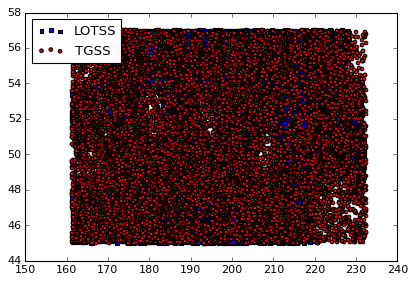

In [7]:
#Plotting coords of two arrays to compare

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(RA_First, DE_First, s=10, c='b', marker="s", label=First_Catalogue_Name)
ax1.scatter(RA_Second,DE_Second, s=10, c='r', marker="o", label=Second_Catalogue_Name)
plt.legend(loc='upper left');
plt.show()

In [8]:
start_time = time.time()
#This loop finds common stars between catalogues:

#Creating new arrays:

#Luminosities of stars in common(and error)
Lum_First_Relevant=[]
Lum_Second_Relevant=[]
Lum_First_Relevant_e=[]
Lum_Second_Relevant_e=[]

#Coordinates of stars in common
RA_First_Relevant=[]
RA_Second_Relevant=[]
DE_First_Relevant=[]
DE_Second_Relevant=[]
RA_First_Relevant_e=[]
RA_Second_Relevant_e=[]
DE_First_Relevant_e=[]
DE_Second_Relevant_e=[]

#Creating new variables

#index for first catalogue:
f=0
#index for second catalogue:
s=0
#number of iterations:
it=0
#Number of stars in both catalogues
corr=1

#While loop goes through all of first catalogue..
while f<len(RA_First):
    #If it compares a source in first catalogue to every source in second without finding one in common then..
    if s==len(RA_Second):
        #It moves on to next source in first and..
        f=f+1
        #Starts comparing it to the first source in the second catalogue
        s=0
    #This is a formula for overlapping circles with the radii being the error
    #If this is true catalogues have that star in common
    elif RA_First_e[f]+RA_Second_e[s]>= abs(RA_First[f]-RA_Second[s]) and DE_First_e[f]+DE_Second_e[s]>= abs(DE_First[f]-DE_Second[s]):
        #print coords and luminosity
#         print corr,":"
#         print First_Catalogue_Name," Coords: (",RA_First[f],",",DE_First[f],")"
#         print First_Catalogue_Name," error: (",RA_First_e[f],",",DE_First_e[f],")"
#         print Second_Catalogue_Name," Coords: (",RA_Second[s],",",DE_Second[s],")"
#         print Second_Catalogue_Name," error: (",RA_Second_e[s],",",DE_Second_e[s],")"
#         print First_Catalogue_Name," Flux:",Lum_First[f]*.001
#         print Second_Catalogue_Name," Flux:",Lum_Second[s]*.001
#         print ""
        #Making arrays of flux of sources in common (and error)
        Lum_First_Relevant.append((Lum_First[f]))
        Lum_Second_Relevant.append(Lum_Second[s])
        Lum_First_Relevant_e.append((Lum_First_e[f]))
        Lum_Second_Relevant_e.append(Lum_Second_e[s])
        
        #Making arrays of coordinates of sources in common 
        RA_First_Relevant.append(RA_First[f])
        RA_Second_Relevant.append(RA_Second[s])
        RA_First_Relevant_e.append(RA_First_e[f])
        RA_Second_Relevant_e.append(RA_Second_e[s])
        DE_First_Relevant.append(DE_First[f])
        DE_Second_Relevant.append(DE_Second[s])
        DE_First_Relevant_e.append(DE_First_e[f])
        DE_Second_Relevant_e.append(DE_Second_e[s])
        
        #Number of common sources increased
        corr=corr+1
        #Move onto next source in first catalogue
        f=f+1
        #Starts comparing it to the first source in the second catalogue
        s=0
    #If neither of these are true then..
    else:
        #Try next source in second catalogue
        s=s+1
    #Before going onto next loop increase number of iterations
    it=it+1
print("--- %s seconds ---" % (time.time() - start_time))

--- 381.987944126 seconds ---


In [9]:
print "Number of iterations:",it
print "Number of stars corrolated:",corr

Number of iterations: 398647014
Number of stars corrolated: 7373


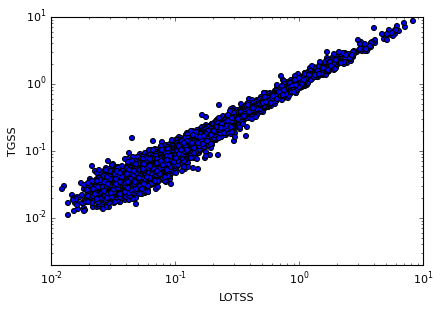

In [10]:
#Plotting Luminosities (unit Jy, log scale)

if corr>0:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(Lum_First_Relevant, Lum_Second_Relevant)
    plt.xlabel(First_Catalogue_Name)
    plt.ylabel(Second_Catalogue_Name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.01,10)
    plt.ylim(0,10)
    plt.show()

In [11]:
#Defining new variables
Fractional_Diff=0
n=0
m=0
Fractional_Diff_list=[]

#This loop goes through the whole lists of common stars

while n<corr-1:
    
    #Calculates nth fractional change
    Fractional_Diff=(abs(Lum_First_Relevant[n]-Lum_Second_Relevant[n]))/Lum_First_Relevant[n]
    #Creates an array of fractional changes
    Fractional_Diff_list.append(Fractional_Diff)
    n=n+1

#When loop is finished it will have found the biggest change in the list

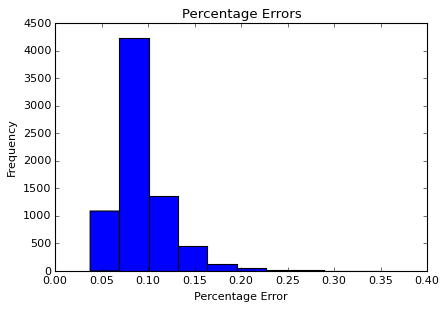

In [31]:

total_percentage_errors_list=[]
n=0
while n<len(Fractional_Diff_list):
    
    #..creates lists of their indexes and coordinates.
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_percentage_errors_list.append(total_percentage_error)
    n=n+1

plt.hist(total_percentage_errors_list)
plt.title("Percentage Errors")
plt.xlabel("Percentage Error")
plt.ylabel("Frequency")


fig = plt.gcf()

In [12]:
#FIRST ATTEMPT

size=10

def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))

#Create a list of the largest fractional changes in flux:
Largest_Fractional_Diffs=heapq.nlargest(size,Fractional_Diff_list)

#Set new lists:
Big_Change_indexes=[]
Big_Change_RAs=[]
Big_Change_DEs=[]
n=0

#This loop goes through the "Largest_Fractional_Diffs" list and...
while n<size:
    
    #..creates lists of their indexes and coordinates.
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
    Big_Change_indexes.append(ind)
    Big_Change_RAs.append(RA_First_Relevant[ind])
    Big_Change_DEs.append(DE_First_Relevant[ind])
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
    #printing relevant information:
    print n,":"
    print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
    print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
    print "Coordinates:",Big_Change_RAs[n],Big_Change_DEs[n]
    print "Total percentage error:",round_to_1(total_percentage_error)
    
    Simbad_table=Simbad.query_region(coord.SkyCoord(Big_Change_RAs[n], Big_Change_DEs[n],unit=(u.deg, u.deg)),radius='0d0m10s')
    
    if not Simbad_table:
            print "==>no source found on SIMBAD"
    else:
        print Simbad_table["MAIN_ID","RA","DEC"]
    print ""
    print ""
    print ""
    n=n+1


0 :
Change in flux: 2.53010156831 ± 0.3
Respective fluxes: 0.04461628 0.1575
Coordinates: 203.036 47.11892
Total percentage error: 0.1


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:32:08.64 +47:07:08.112': No astronomical object found :
  (error.line, error.msg))


==>no source found on SIMBAD



1 :
Change in flux: 1.71487944864 ± 0.3
Respective fluxes: 0.02147425 0.0583
Coordinates: 217.38867 47.25709
Total percentage error: 0.2
==>no source found on SIMBAD



2 :
Change in flux: 1.41386324135 ± 0.2
Respective fluxes: 0.02895773 0.0699
Coordinates: 206.76624 46.42481
Total percentage error: 0.1
==>no source found on SIMBAD



3 :
Change in flux: 1.38031032604 ± 0.3
Respective fluxes: 0.01264541 0.0301
Coordinates: 172.18192 47.14743
Total percentage error: 0.2
==>no source found on SIMBAD



4 :
Change in flux: 1.20353437537 ± 0.1
Respective fluxes: 0.04265874 0.094
Coordinates: 229.18089 48.48004
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J151643+482848 15 16 43.20 +48 28 48.0



5 :
Change in flux: 1.20242957567 ± 0.3
Respective fluxes: 0.01216838 0.0268
Coordinates: 217.93641 46.41554
Total percentage error: 0.2


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:29:33.2808 +47:15:25.524': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:47:03.8976 +46:25:29.316': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:28:43.6608 +47:08:50.748': No astronomical object found :
  (error.line, error.msg))


      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J143144+462457 14 31 44.51 +46 24 57.1



6 :
Change in flux: 1.19419421562 ± 0.3
Respective fluxes: 0.02242281 0.0492
Coordinates: 177.36783 46.36439
Total percentage error: 0.2
==>no source found on SIMBAD



7 :
Change in flux: 1.14764361292 ± 0.3
Respective fluxes: 0.22438546 0.4819
Coordinates: 163.93772 45.40041
Total percentage error: 0.2
      MAIN_ID            RA          DEC     
                      "h:m:s"      "d:m:s"   
------------------- ------------ ------------
NVSS J105545+452401 10 55 44.993 +45 24 01.10



8 :
Change in flux: 1.11716699899 ± 0.2
Respective fluxes: 0.02418326 0.0512
Coordinates: 172.7765 55.3134
Total percentage error: 0.2
==>no source found on SIMBAD



9 :
Change in flux: 1.10524212857 ± 0.1
Respective fluxes: 0.06607316 0.1391
Coordinates: 193.77652 46.69134
Total percentage error: 0.1
      MAIN_ID           

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:49:28.2792 +46:21:51.804': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:31:06.36 +55:18:48.24': No astronomical object found :
  (error.line, error.msg))


In [13]:
#SECOND ATTEMPT


#Create a list of the largest fractional changes in flux:
Largest_Fractional_Diffs=sorted(Fractional_Diff_list,reverse=True)

#Creat new lists:
Big_Change_indexes=[]
Big_Change_RAs=[]
Big_Change_DEs=[]

#Creat new variables:
n=0
m=0

#This loop goes through the "Largest_Fractional_Diffs" list and...
while m<size:
    
    if n>=len(Largest_Fractional_Diffs):
        print "No other sources meet criterea"
        break
    
    #..creates lists of their indexes and coordinates.
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
    Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m10s')
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
    if  Simbad_table:
    #printing relevant information:
        Big_Change_indexes.append(ind)
        Big_Change_RAs.append(RA_First_Relevant[ind])
        Big_Change_DEs.append(DE_First_Relevant[ind])
        print m,":"
        print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
        print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
        print "Coordinates:",RA_First_Relevant[ind],DE_First_Relevant[ind]
        print "Total percentage error:",round_to_1(total_percentage_error)
        print Simbad_table["MAIN_ID","RA","DEC"]
        print ""
        print ""
        print ""
        m=m+1
    n=n+1


0 :
Change in flux: 1.20353437537 ± 0.1
Respective fluxes: 0.04265874 0.094
Coordinates: 229.18089 48.48004
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J151643+482848 15 16 43.20 +48 28 48.0



1 :
Change in flux: 1.20242957567 ± 0.3
Respective fluxes: 0.01216838 0.0268
Coordinates: 217.93641 46.41554
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J143144+462457 14 31 44.51 +46 24 57.1



2 :
Change in flux: 1.14764361292 ± 0.3
Respective fluxes: 0.22438546 0.4819
Coordinates: 163.93772 45.40041
Total percentage error: 0.2
      MAIN_ID            RA          DEC     
                      "h:m:s"      "d:m:s"   
------------------- ------------ ------------
NVSS J105545+452401 10 55 44.993 +45 24 01.10



3 :
Change in flux: 1.10524212857 ± 0.1
Respe

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '10:59:17.9472 +45:28:03.792': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:34:13.0464 +53:12:31.428': No astronomical object found :
  (error.line, error.msg))


7 :
Change in flux: 0.930717641666 ± 0.1
Respective fluxes: 0.03946719 0.0762
Coordinates: 215.09163 47.21918
Total percentage error: 0.1
        MAIN_ID               RA          DEC     
                           "h:m:s"      "d:m:s"   
------------------------ ------------ ------------
SDSS J142021.93+471309.0 14 20 21.938 +47 13 09.06
     NVSS J142021+471305  14 20 21.26  +47 13 05.3



8 :
Change in flux: 0.900325690585 ± 0.2
Respective fluxes: 0.02694275 0.0512
Coordinates: 230.01377 48.76511
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J152003+484546 15 20 03.30 +48 45 54.0





/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:05:02.2056 +55:16:47.784': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:42:44.2632 +45:06:08.172': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:26:48.5568 +53:48:22.392': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warni

9 :
Change in flux: 0.810995328782 ± 0.08
Respective fluxes: 0.041745 0.0756
Coordinates: 196.56695 49.70918
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J130616+494234 13 06 16.00 +49 42 33.0





In [33]:
#THIRD ATTEMPT

size=20

#Create a list of the largest fractional changes in flux:
Largest_Fractional_Diffs=sorted(Fractional_Diff_list,reverse=True)

#Creat new lists:
Big_Change_indexes=[]
Big_Change_RAs=[]
Big_Change_DEs=[]

#Creat new variables:
n=0
m=0

#This loop goes through the "Largest_Fractional_Diffs" list and...
while m<size:
    
    if n>=len(Largest_Fractional_Diffs):
        print "No other sources meet criterea"
        break
    
    #..creates lists of their indexes and coordinates.
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
    try:
        Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m10s')
    except EOFError:
        print "EOFError"
        n=n+1
        continue
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
    if  total_percentage_error<=.09:
    #printing relevant information:
        Big_Change_indexes.append(ind)
        Big_Change_RAs.append(RA_First_Relevant[ind])
        Big_Change_DEs.append(DE_First_Relevant[ind])
        print m,":"
        print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
        print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
        print "Coordinates:",RA_First_Relevant[ind],DE_First_Relevant[ind]
        print "Total percentage error:",round_to_1(total_percentage_error)
        
        if not Simbad_table:
            print "==>no source found on SIMBAD"
        else:
            print Simbad_table["MAIN_ID","RA","DEC"]
        
        print ""
        print ""
        print ""
        m=m+1
    n=n+1


0 :
Change in flux: 0.658090030701 ± 0.05
Respective fluxes: 0.09300694 0.0318
Coordinates: 183.68359 54.58016
Total percentage error: 0.07
==>no source found on SIMBAD



1 :
Change in flux: 0.657098924163 ± 0.06
Respective fluxes: 0.15368864 0.0527
Coordinates: 186.47155 53.15344
Total percentage error: 0.08
==>no source found on SIMBAD



2 :
Change in flux: 0.619915950369 ± 0.05
Respective fluxes: 0.07051072 0.0268
Coordinates: 201.21004 56.65039
Total percentage error: 0.08
==>no source found on SIMBAD



3 :
Change in flux: 0.611234084466 ± 0.05
Respective fluxes: 0.05709909 0.092
Coordinates: 211.90289 48.62731
Total percentage error: 0.09
         MAIN_ID                RA           DEC     
                             "h:m:s"       "d:m:s"   
------------------------- ------------- -------------
[VV2010] J140736.7+483737 14 07 36.6473 +48 37 37.500



4 :
Change in flux: 0.604526542666 ± 0.05
Respective fluxes: 0.06018103 0.0238
Coordinates: 197.51396 53.89665
Total percentag

/Users/niallbradley/anaconda/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:


INFO: Auto-setting vmin to  1.823e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.427e+04 [aplpy.core]


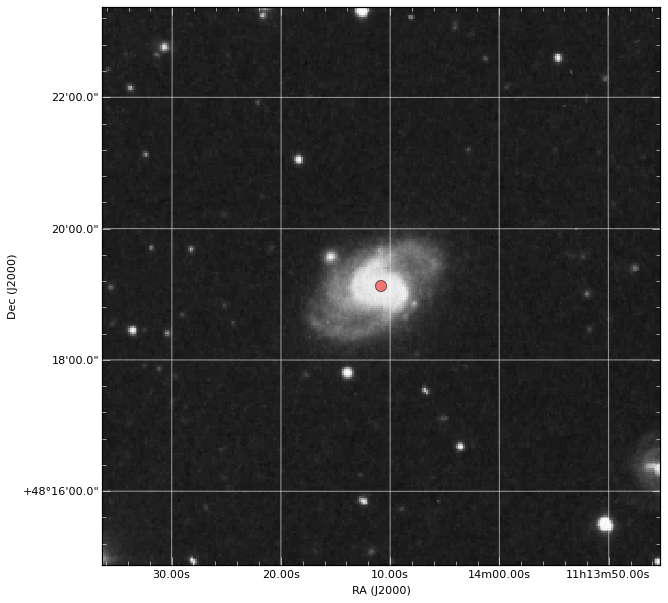

In [34]:
#This displays image of a correlated source

#Which source to show:
x=16

#Coordinates of this star:
pos=coord.SkyCoord(Big_Change_RAs[x]*u.deg, Big_Change_DEs[x]*u.deg)
ra=np.array([Big_Change_RAs[x]])
de=np.array([Big_Change_DEs[x]])
#Find image from DSS:
images = SkyView.get_images(pos,survey=['DSS'])
print images[0]

CV = aplpy.FITSFigure(images[0])


#Gives in grid and makes it grayscale (can also be made colorscale)
CV.show_grayscale()
CV.add_grid()

#This plots a circle where the relevant source should be 
x_pix, y_pix = CV.world2pixel(ra,de)
plt.scatter(x_pix, y_pix, s=100, c='red', alpha=.5)
plt.show()